In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cbm_pack.file_utils as file_utils
import cbm_pack.transform as transform
import cbm_pack.analysis as analysis
from copy import deepcopy
import os.path

TRIAL_TIME = 5000 # in ms
MS_PER_HOUR = 3_600_000
MS_PER_SIX_MIN = 360_000
MAX_CR_AMP = 6

ISI = 500
PRE_CS_COLLECT_TS = 400
POST_CS_COLLECT_TS = 400

PYTHON_SCRIPTS_PATH = "/home/seang/Dev/Scripts/Python/"

DATA_INPUT_DIR = f"{PYTHON_SCRIPTS_PATH}data/inputs/"
FORGET_DATA_INPUTS_PATH = f"{DATA_INPUT_DIR}Forgetting/"

EXTENSIONS = {
    "mf_raster" : ".mfr",
    "gr_raster" : ".grr",
    "go_raster" : ".gor",
    "pc_raster" : ".pcr",
    "bc_raster" : ".bcr",
    "sc_raster" : ".scr",
    "nc_raster" : ".ncr",
    "io_raster" : ".ior",
    "mf_psth" : ".mfp", 
    "gr_psth" : ".grp",
    "go_psth" : ".gop",
    "pc_psth" : ".pcp",
    "bc_psth" : ".bcp",
    "sc_psth" : ".scp",
    "nc_psth" : ".ncp",
    "io_psth" : ".iop",
    "pfpc_weights" : ".pfpcw",
    "mfnc_weights" : ".mfncw"
}

CELL_NUMS = {
    "mf" : 4096,
    "gr" : 2 ** 20,
    "go" : 4096,
    "pc" : 32,
    "bc" : 128,
    "sc" : 512,
    "nc" : 8,
    "io" : 4
}

In [59]:
def compute_crs_over_one_file(
        num_trials: int, input_pc_file: str) -> np.ndarray:
    num_collect_ts = PRE_CS_COLLECT_TS + ISI + POST_CS_COLLECT_TS
    pc_rasters = file_utils.np_arr_from_file(input_pc_file, np.uint8)
    pc_rasters = transform.reshape_raster( \
            pc_rasters, \
            CELL_NUMS["pc"], \
            num_trials, \
            num_collect_ts)

    pc_crs = analysis.pcs_to_crs(pc_rasters, PRE_CS_COLLECT_TS, POST_CS_COLLECT_TS, ISI)
    return pc_crs     

def compute_crs_over_files(
    out_keys: list, file_list: list, num_trials: list
) -> dict:
    return_dict = dict()
    for i, file in enumerate(file_list):
        return_dict[out_keys[i]] = compute_crs_over_one_file(num_trials[i], file)
    return return_dict

def plot_acq_curve_no_probe(
    pc_crs: np.ndarray,
    plot_style: str,
    num_acq_trials: int
) -> None:
    trials_to_plot = np.arange(0, num_acq_trials-300, 5)
    cr_amps = np.max(pc_crs, axis=1)
    fig = plt.figure()
    #fig.suptitle("Forgetting", fontsize=14)
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    ax.plot(trials_to_plot, cr_amps[0:num_acq_trials-300:5], plot_style)
    ax.set_xlabel('trials', fontsize=12)
    ax.set_ylabel('eyelid closure (mm)', fontsize=12)
    ax.set_ylim((0, MAX_CR_AMP+0.5))
    plt.tight_layout()
    plt.show()
    plt.close(fig)

def plot_cr_at_trial(
    pc_crs: np.ndarray, plot_style: str, trial: int) -> None:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    ax.set_xlabel('time (ms)', fontsize=12)
    ax.set_ylabel('eyelid closure (mm)', fontsize=12)
    ax.plot(pc_crs[trial], plot_style)
    ax.set_ylim((0, MAX_CR_AMP+0.5))
    plt.tight_layout()
    plt.show()
    plt.close(fig)

def plot_single_forget_curve_std_time_metric(
        pc_crs: np.ndarray,
        clr: str, ms: int, ls: str, probe_trials_per_block: int,
        num_blocks: int) -> None:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    ax.set_xlabel('time (hours)', fontsize=12)
    ax.set_ylabel('eyelid closure (mm)', fontsize=12)
    hour_pts_to_plot = np.arange(num_blocks)
    mean_crs_blocks = np.zeros(num_blocks)
    trial_start = 0
    trial_end = probe_trials_per_block
    for block in np.arange(num_blocks):
            mean_crs_blocks[block] = np.mean(np.max(pc_crs[trial_start:trial_end], axis=1))
            trial_start += probe_trials_per_block
            trial_end += probe_trials_per_block
    ax.plot(hour_pts_to_plot, mean_crs_blocks, 'o', linestyle=ls,
        color=clr, markersize=2.0)
    # final setup stuff
    ax.set_ylim((0, MAX_CR_AMP+0.5))
    plt.tight_layout()
    plt.show()
    plt.close(fig)

def plot_multiple_forget_curves_std_time_metric(
        pc_crs: dict, conditions: list,
        styles: list, probe_trials_per_block: list,
        num_blocks: list) -> None:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    ax.set_xlabel('time (hours)', fontsize=12)
    ax.set_ylabel('eyelid closure (mm)', fontsize=12)
    # here assume each array is in sorted order
    for i, key in enumerate(sorted(pc_crs.keys())):
        hour_pts_to_plot = np.arange(num_blocks[i])
        mean_crs_blocks = np.zeros(num_blocks[i])
        trial_start = 0
        trial_end = probe_trials_per_block[i]
        for block in np.arange(num_blocks[i]):
                mean_crs_blocks[block] = np.mean(np.max(pc_crs[key][trial_start:trial_end], axis=1))
                trial_start += probe_trials_per_block[i]
                trial_end += probe_trials_per_block[i]
        ax.plot(hour_pts_to_plot, mean_crs_blocks, styles[i], markersize=2.0)
    # final setup stuff
    ax.set_ylim((0, MAX_CR_AMP+0.5))
    plt.tight_layout()
    plt.show()
    plt.close(fig)

def plot_mean_cr_over_probe_at_forget_trial(
    pc_crs: np.ndarray, hour_pt: int,
    probe_trials_per_block: int, color: str):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    ax.set_xlabel('time (ms)', fontsize=12)
    ax.set_ylabel('eyelid closure (mm)', fontsize=12)
    trial = hour_pt * probe_trials_per_block
    data_collect_ms = PRE_CS_COLLECT_TS + ISI + POST_CS_COLLECT_TS
    mean_probe_cr_at_trial = np.mean(pc_crs[trial:trial+probe_trials_per_block], axis=0)
    ci = 1.96 * np.std(pc_crs[trial:trial+probe_trials_per_block], axis=0) / np.sqrt(probe_trials_per_block)
    ax.plot(mean_probe_cr_at_trial, '-', color=color, linewidth=1.0)
    ax.fill_between(np.arange(data_collect_ms), (mean_probe_cr_at_trial-ci),
        (mean_probe_cr_at_trial+ci), color=color, alpha=0.1)
    ax.set_ylim((0, MAX_CR_AMP+1))
    plt.tight_layout()
    plt.show()
    plt.close(fig)

def plot_probe_crs(
    probe_pc_cr_amps: np.ndarray, conditions: list, xlabel: str, plot_style: str
) -> None:
    assert len(probe_pc_cr_amps) == len(conditions)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('eyelid closure (mm)', fontsize=12)
    ax.plot(conditions, probe_pc_cr_amps, plot_style, markersize=2.5)
    ax.set_ylim((0, MAX_CR_AMP+1))
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [5]:
acq_input_base = "acq_commit_c2e8bb7_test_1_ISI_500"
input_pc_file = f"{FORGET_DATA_INPUTS_PATH}/{acq_input_base}/{acq_input_base}{EXTENSIONS['pc_raster']}"
num_acq_trials = 500
pc_crs = compute_crs_over_one_file(
        num_acq_trials, input_pc_file)


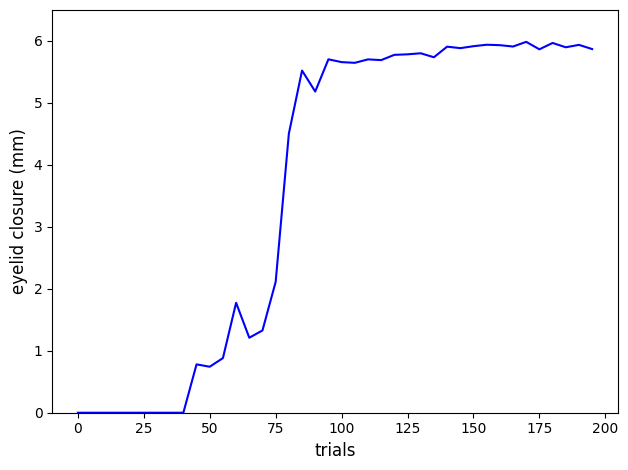

In [6]:
plot_acq_curve_no_probe(
    pc_crs,
    'b-',
    num_acq_trials
)

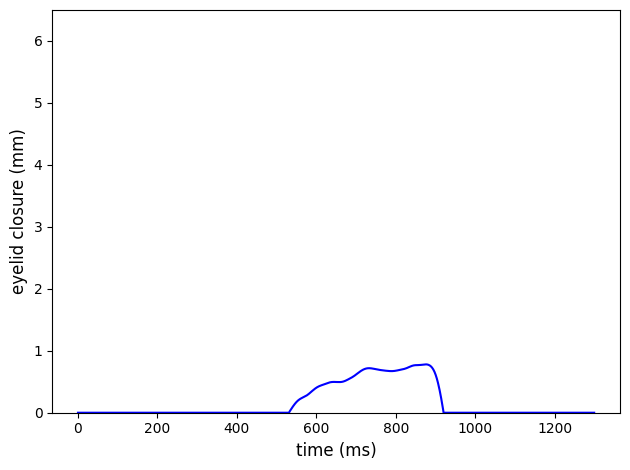

In [7]:
plot_cr_at_trial(
    pc_crs, 'b-', 45)

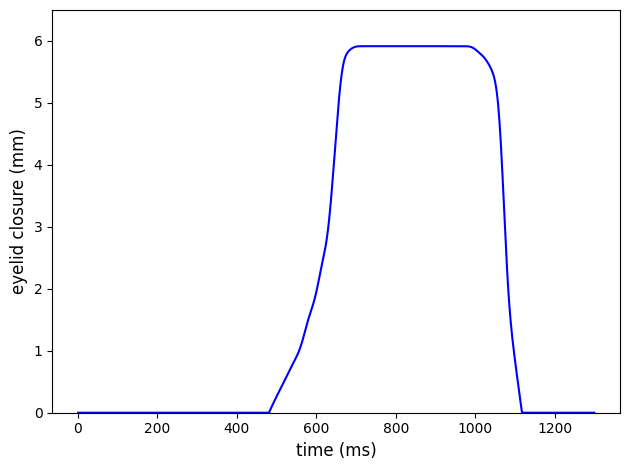

In [8]:
plot_cr_at_trial(
    pc_crs, 'b-', 150)

In [9]:
forget_input_base = "forget_learner_conn_ISI_500"
forget_pc_file = f"{FORGET_DATA_INPUTS_PATH}/{forget_input_base}/{forget_input_base}{EXTENSIONS['pc_raster']}"
num_blocks = 29 # NOTE: expect an additional probe block at beginning
num_probe_trials_per_block = 50
num_tot_probe_trials = num_blocks * num_probe_trials_per_block
forget_pc_crs = compute_crs_over_one_file(
        num_tot_probe_trials, forget_pc_file)

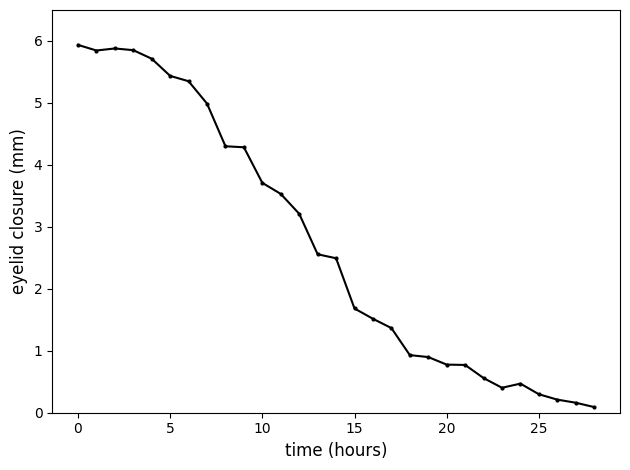

In [21]:
plot_single_forget_curve_std_time_metric(
        forget_pc_crs, 'k', 2, '-', num_probe_trials_per_block,
        num_blocks)

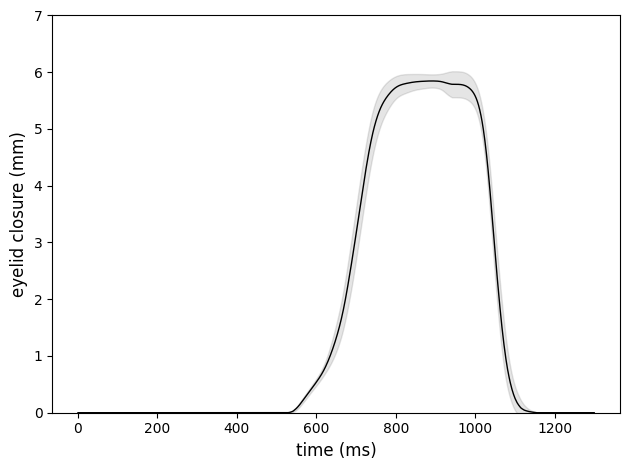

In [60]:
plot_mean_cr_over_probe_at_forget_trial(
    forget_pc_crs, 1,
    num_probe_trials_per_block, 'k'
)

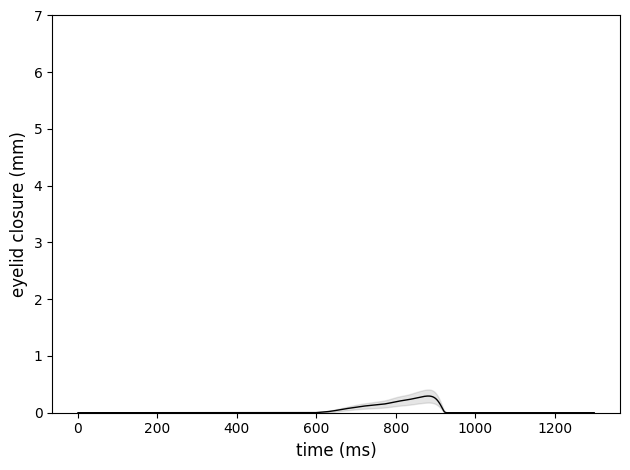

In [62]:
plot_mean_cr_over_probe_at_forget_trial(
    forget_pc_crs, 25,
    num_probe_trials_per_block, 'k'
)

In [32]:
probe_base = "probe_abs_w_mar_2024_isi_500_reset"
reset_nums = [num for num in range(0, 20500, 500)]
probe_files = [f"{FORGET_DATA_INPUTS_PATH}{probe_base}_{num}/{probe_base}_{num}{EXTENSIONS['pc_raster']}" for num in reset_nums]
num_probe_trials = 50
probe_pc_cr_amps = []
for file in probe_files:
    probe_pc_cr_amps.append(np.mean(np.max(compute_crs_over_one_file(num_probe_trials, file), axis=1)))

probe_pc_cr_amps = np.array(probe_pc_cr_amps)

/home/seang/Dev/Scripts/Python/.venv/lib/python3.11/site-packages/cbm_pack/analysis.py:38: RuntimeWarning: invalid value encountered in divide
  crs = crs / norm


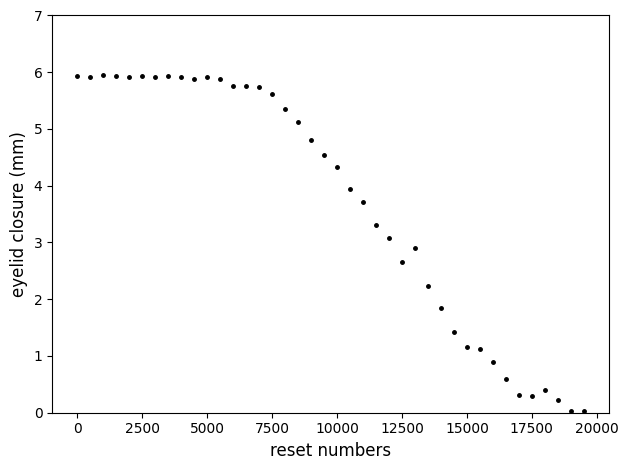

In [42]:
plot_probe_crs(
    probe_pc_cr_amps, reset_nums, "reset numbers", 'ko')

In [15]:
freeze_nums = ["0", "10000", "20000", "30000"]

forget_freeze_bases = [
    "forget_learner_conn_ISI_500",
    "forget_hour_blocks_freeze_10000_abs_w_ISI_500",
    "forget_hour_blocks_freeze_20000_abs_w_ISI_500",
    "forget_hour_blocks_freeze_30000_abs_w_ISI_500"
]

forget_freeze_files = [
   f"{FORGET_DATA_INPUTS_PATH}/{base}/{base}{EXTENSIONS['pc_raster']}" for base in forget_freeze_bases
]

num_blocks = 29 # NOTE: expect an additional probe block at beginning
num_probe_trials_per_block = 50
num_tot_probe_trials = num_blocks * num_probe_trials_per_block

forget_freeze_num_trials = len(freeze_nums) * [num_tot_probe_trials]

forget_freeze_crs = compute_crs_over_files(
    freeze_nums, forget_freeze_files, forget_freeze_num_trials
)

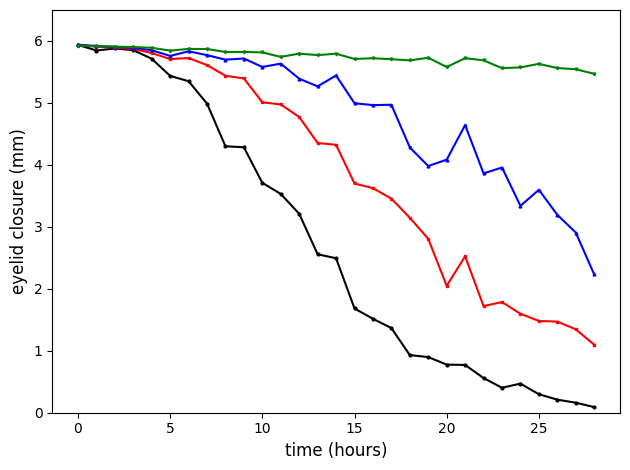

In [22]:
freeze_plot_styles = [
    'ko-', 'rs-', 'b^-', 'gv-'
]

num_blockss = len(freeze_nums) * [num_blocks]
probe_trials_per_blocks = len(freeze_nums) * [num_probe_trials_per_block]

plot_multiple_forget_curves_std_time_metric(
        forget_freeze_crs, freeze_nums,
        freeze_plot_styles, probe_trials_per_blocks,
        num_blockss
)